0.8974222792100963


TypeError: unsupported operand type(s) for /: 'float' and 'NoneType'

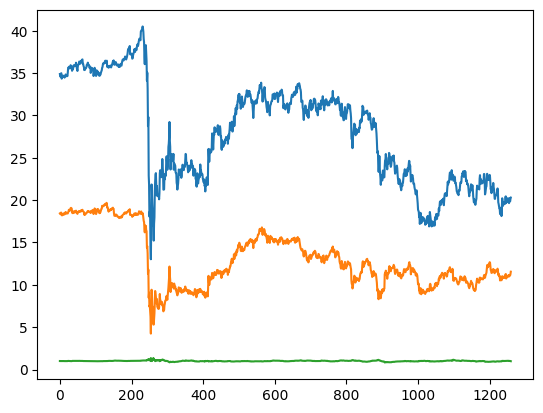

In [16]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Apr  8 00:46:26 2024

@author: nikola
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import minimize
import time
import math
import datetime
import scipy as sc
#from pandas_datareader import data as pdr
#from IPython.display import display, Latex
#from statsmodels.graphics.tsaplots import plot_acf
import scipy.stats as ss
import random
# Load data
ARI = pd.read_csv(r"C:\Users\DELL\OneDrive\Desktop\ARI.csv")
BXMT = pd.read_csv(r"C:\Users\DELL\OneDrive\Desktop\BXMT.csv")

# Extract 'Close' prices
ari = ARI['Close'].copy()
bxmt = BXMT['Close'].copy()

# Create series with the last 1260 values
x1 = pd.Series(list(bxmt[-1260:]))
x2 = pd.Series(list(ari[-1260:]))

data1 = ari.copy()
data2 = bxmt.copy()

# Calculate the ratio and its rolling average
ratio = pd.Series([x/y for x, y in zip(x1, x2)])
rolling_avg = ratio.rolling(window=40).mean()
rolling_avg.iloc[:39] = rolling_avg.iloc[39]

# Plot the data
plt.plot(x1)
plt.plot(x2)

print(x1.corr(x2))

# Calculate the spread
spread = [x/(k*y) for x, y, k in zip(x1, x2, rolling_avg)]
plt.plot(spread)

# Convert to series
x1 = pd.Series(x1)
x2 = pd.Series(x2)
spread = pd.Series(spread)

# Save original series
x1_orig = x1.copy()
x2_orig = x2.copy()
spread_orig = spread.copy()

# Remove the last 252 values
x1 = x1_orig.iloc[:-252]
x2 = x2_orig.iloc[:-252]
spread = spread_orig.iloc[:-252]

# Define functions for optimization
def mu(x, dt, kappa, theta):
    ekt = np.exp(-kappa*dt)
    return x * ekt + theta * (1 - ekt)

def std(dt, kappa, sigma):
    e2kt = np.exp(-2 * kappa * dt)
    std_val = sigma * np.sqrt((1 - e2kt) / (2 * kappa + 1e-10))  # Adding a small constan



def log_likelihood_OU(theta_hat, x):
    kappa = theta_hat[0]
    theta = theta_hat[1]
    sigma = theta_hat[2]

    x_dt = x[1:]
    x_t = x[:-1]

    dt = 1
    mu_OU = mu(x_t, dt, kappa, theta)
    sigma_OU = std(dt, kappa, sigma)
    
    l_theta_hat = np.sum(np.log(sc.stats.norm.pdf(x_dt, loc=mu_OU, scale=sigma_OU)))
    return -l_theta_hat

def kappa_pos(theta_hat):
    kappa = theta_hat[0]
    return kappa

def sigma_pos(theta_hat):
    sigma = theta_hat[2]
    return sigma

# Initial guess and constraints
vol = np.array(spread)
cons_set = [{'type': 'ineq', 'fun': kappa_pos}, {'type': 'ineq', 'fun': sigma_pos}]
theta0 = [0.0001, np.mean(vol), np.std(vol)]

# Optimization
opt = sc.optimize.minimize(fun=log_likelihood_OU, x0=theta0, args=(vol,), constraints=cons_set)
kappa = round(opt.x[0], 3)
theta = round(opt.x[1], 3)
sigma = round(opt.x[2], 3)

# Gradient descent part
def func(x):
    return log_likelihood_OU(x, spread)

def dfunc(X):
    dLambda = np.zeros(len(X))
    h = 1e-3  # Step size for finite difference
    for i in range(len(X)):
        dX = np.zeros(len(X))
        dX[i] = h
        dLambda[i] = (func(X + dX) - func(X - dX)) / (2 * h)
    return dLambda

def gradient_descent(objective, step_size, n_iterations, initial_solution):
    solutions = []  # Store solutions for visualization
    scores = []     # Store scores for visualization

    solution = initial_solution
    solution_eval = objective(initial_solution)
    
    # Iterative optimization loop
    for i in range(n_iterations):
        gradient = dfunc(solution)  # Compute gradient
        new_solution = solution - step_size * gradient  # Update solution
        new_solution_eval = objective(new_solution)    # Evaluate new solution
        
        # Update solution if improvement is found
        if new_solution_eval < solution_eval:
            solution = new_solution
            solution_eval = new_solution_eval
            solutions.append(solution)
            scores.append(solution_eval)
            print('>%d f(%s) = %.5f' % (i, solution, solution_eval))
            
    return solutions, scores

# Set seed for reproducibility
#seed(1)

# Parameters
n_iterations = 10000
step_size = 0.000001
initial_solution = [1, np.mean(spread), np.std(spread)]

# Perform gradient descent
solutions, scores = gradient_descent(func, step_size, n_iterations, initial_solution)

# Visualize the optimization process
plt.plot(scores)
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.title('Gradient Descent Performance')
plt.show()

# Print the final solution
final_solution = solutions[-1]
print("Final solution:", final_solution)

# Assign the final solution values
kappa = final_solution[0]
theta = final_solution[1]
sigma = final_solution[2]

kappa_mle = kappa
theta_mle = theta
sigma_mle = sigma


0.8974222792100963
Invalid sigma_OU: -3.810368461525449e-05
Invalid sigma_OU: -0.0033617289185760815
Invalid sigma_OU: -2.161642488985309e-09
Invalid sigma_OU: 0.0
>0 f([0.09999995 0.09999995]) = -1.99499
>1 f([0.0999999 0.0999999]) = -1.99499
>2 f([0.09999985 0.09999985]) = -1.99499
>3 f([0.0999998 0.0999998]) = -1.99499
>4 f([0.09999975 0.09999975]) = -1.99499
>5 f([0.0999997 0.0999997]) = -1.99499
>6 f([0.09999965 0.09999965]) = -1.99499
>7 f([0.0999996 0.0999996]) = -1.99499
>8 f([0.09999955 0.09999955]) = -1.99499
>9 f([0.0999995 0.0999995]) = -1.99499
>10 f([0.09999945 0.09999945]) = -1.99499
>11 f([0.0999994 0.0999994]) = -1.99499
>12 f([0.09999935 0.09999935]) = -1.99499
>13 f([0.0999993 0.0999993]) = -1.99499
>14 f([0.09999925 0.09999925]) = -1.99499
>15 f([0.0999992 0.0999992]) = -1.99499
>16 f([0.09999915 0.09999915]) = -1.99499
>17 f([0.0999991 0.0999991]) = -1.99499
>18 f([0.09999905 0.09999905]) = -1.99499
>19 f([0.099999 0.099999]) = -1.99499
>20 f([0.09999895 0.09999895

C:\Users\DELL\AppData\Local\Temp\ipykernel_12872\119432655.py:93: RuntimeWarning: divide by zero encountered in log
  l_theta_hat = np.sum(np.log(sc.stats.norm.pdf(x_dt, loc=mu_OU, scale=sigma_OU)))


>2517 f([0.09987386 0.09987386]) = -1.99501
>2518 f([0.09987381 0.09987381]) = -1.99501
>2519 f([0.09987376 0.09987376]) = -1.99501
>2520 f([0.09987371 0.09987371]) = -1.99501
>2521 f([0.09987366 0.09987366]) = -1.99501
>2522 f([0.09987361 0.09987361]) = -1.99501
>2523 f([0.09987356 0.09987356]) = -1.99501
>2524 f([0.09987351 0.09987351]) = -1.99501
>2525 f([0.09987346 0.09987346]) = -1.99501
>2526 f([0.09987341 0.09987341]) = -1.99501
>2527 f([0.09987336 0.09987336]) = -1.99501
>2528 f([0.09987331 0.09987331]) = -1.99501
>2529 f([0.09987326 0.09987326]) = -1.99501
>2530 f([0.09987321 0.09987321]) = -1.99501
>2531 f([0.09987316 0.09987316]) = -1.99501
>2532 f([0.09987311 0.09987311]) = -1.99501
>2533 f([0.09987306 0.09987306]) = -1.99501
>2534 f([0.09987301 0.09987301]) = -1.99501
>2535 f([0.09987296 0.09987296]) = -1.99501
>2536 f([0.09987291 0.09987291]) = -1.99501
>2537 f([0.09987286 0.09987286]) = -1.99501
>2538 f([0.09987281 0.09987281]) = -1.99501
>2539 f([0.09987276 0.09987276])

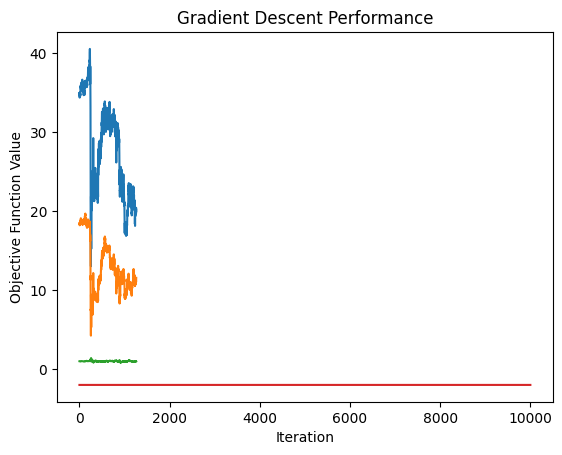

Final solution: [0.09950001 0.09950001]


IndexError: index 2 is out of bounds for axis 0 with size 2

In [19]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Apr  8 00:46:26 2024

@author: nikola
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import minimize
import time
import math
import datetime
import scipy as sc
import scipy.stats as ss
import random

# Load data
ARI = pd.read_csv(r"C:\Users\DELL\OneDrive\Desktop\ARI.csv")
BXMT = pd.read_csv(r"C:\Users\DELL\OneDrive\Desktop\BXMT.csv")

# Extract 'Close' prices
ari = ARI['Close'].copy()
bxmt = BXMT['Close'].copy()

# Create series with the last 1260 values
x1 = pd.Series(list(bxmt[-1260:]))
x2 = pd.Series(list(ari[-1260:]))

data1 = ari.copy()
data2 = bxmt.copy()

# Calculate the ratio and its rolling average
ratio = pd.Series([x/y for x, y in zip(x1, x2)])
rolling_avg = ratio.rolling(window=40).mean()
rolling_avg.iloc[:39] = rolling_avg.iloc[39]

# Plot the data
plt.plot(x1)
plt.plot(x2)

print(x1.corr(x2))

# Calculate the spread
spread = [x/(k*y) for x, y, k in zip(x1, x2, rolling_avg)]
plt.plot(spread)

# Convert to series
x1 = pd.Series(x1)
x2 = pd.Series(x2)
spread = pd.Series(spread)

# Save original series
x1_orig = x1.copy()
x2_orig = x2.copy()
spread_orig = spread.copy()

# Remove the last 252 values
x1 = x1_orig.iloc[:-252]
x2 = x2_orig.iloc[:-252]
spread = spread_orig.iloc[:-252]

# Define functions for optimization
def mu(x, dt, kappa, theta):
    ekt = np.exp(-kappa * dt)
    return x * ekt + theta * (1 - ekt)

def std(dt, kappa, sigma):
    e2kt = np.exp(-2 * kappa * dt)
    std_val = sigma * np.sqrt((1 - e2kt) / (2 * kappa + 1e-10))  # Adding a small constant
    return std_val

def log_likelihood_OU(theta_hat, x):
    kappa = theta_hat[0]
    theta = theta_hat[1]
    sigma = theta_hat[2]

    x_dt = x[1:]
    x_t = x[:-1]

    dt = 1
    mu_OU = mu(x_t, dt, kappa, theta)
    sigma_OU = std(dt, kappa, sigma)
    
    # Check for invalid values in sigma_OU
    if np.any(sigma_OU <= 0):
        print(f"Invalid sigma_OU: {sigma_OU}")
        return np.inf
    
    l_theta_hat = np.sum(np.log(sc.stats.norm.pdf(x_dt, loc=mu_OU, scale=sigma_OU)))
    return -l_theta_hat

def kappa_pos(theta_hat):
    kappa = theta_hat[0]
    return kappa

def sigma_pos(theta_hat):
    sigma = theta_hat[2]
    return sigma

# Initial guess and constraints
vol = np.array(spread)
cons_set = [{'type': 'ineq', 'fun': kappa_pos}, {'type': 'ineq', 'fun': sigma_pos}]
theta0 = [0.0001, np.mean(vol), np.std(vol)]

# Optimization
opt = sc.optimize.minimize(fun=log_likelihood_OU, x0=theta0, args=(vol,), constraints=cons_set)
kappa = round(opt.x[0], 3)
theta = round(opt.x[1], 3)
sigma = round(opt.x[2], 3)

# Gradient descent part
#def func(x):
#    return log_likelihood_OU(x, spread)


def func(x):

    return -np.sqrt(4-x[0]**2-x[1]**2)
def dfunc(X):
    dLambda = np.zeros(len(X))
    h = 1e-3  # Step size for finite difference
    for i in range(len(X)):
        dX = np.zeros(len(X))
        dX[i] = h
        dLambda[i] = (func(X + dX) - func(X - dX)) / (2 * h)
    return dLambda

def gradient_descent(objective, step_size, n_iterations, initial_solution):
    solutions = []  # Store solutions for visualization
    scores = []     # Store scores for visualization

    solution = initial_solution
    solution_eval = objective(initial_solution)
    
    # Iterative optimization loop
    for i in range(n_iterations):
        gradient = dfunc(solution)  # Compute gradient
        new_solution = solution - step_size * gradient  # Update solution
        new_solution_eval = objective(new_solution)    # Evaluate new solution
        
        # Update solution if improvement is found
        if new_solution_eval < solution_eval:
            solution = new_solution
            solution_eval = new_solution_eval
            solutions.append(solution)
            scores.append(solution_eval)
            print('>%d f(%s) = %.5f' % (i, solution, solution_eval))
            
    return solutions, scores

# Set seed for reproducibility
#seed(1)

# Parameters
n_iterations = 10000
step_size = 0.000001
#initial_solution = [1, np.mean(spread), np.std(spread)]
initial_solution = [0.1, 0.1]
# Perform gradient descent
solutions, scores = gradient_descent(func, step_size, n_iterations, initial_solution)

# Visualize the optimization process
plt.plot(scores)
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.title('Gradient Descent Performance')
plt.show()

# Print the final solution
final_solution = solutions[-1]
print("Final solution:", final_solution)

# Assign the final solution values
kappa = final_solution[0]
theta = final_solution[1]
sigma = final_solution[2]

kappa_mle = kappa
theta_mle = theta
sigma_mle = sigma


>0 f([0.1000054 0.099982 ]) = 1.61965
>1 f([0.1000108 0.099964 ]) = 1.61929
>2 f([0.1000162  0.09994601]) = 1.61894
>3 f([0.1000216  0.09992802]) = 1.61859
>4 f([0.10002699 0.09991004]) = 1.61824
>5 f([0.10003239 0.09989206]) = 1.61788
>6 f([0.10003779 0.09987408]) = 1.61753
>7 f([0.10004318 0.09985611]) = 1.61718
>8 f([0.10004858 0.09983814]) = 1.61683
>9 f([0.10005397 0.09982017]) = 1.61648
>10 f([0.10005937 0.09980221]) = 1.61612
>11 f([0.10006476 0.09978425]) = 1.61577
>12 f([0.10007015 0.0997663 ]) = 1.61542
>13 f([0.10007555 0.09974835]) = 1.61507
>14 f([0.10008094 0.0997304 ]) = 1.61472
>15 f([0.10008633 0.09971246]) = 1.61437
>16 f([0.10009172 0.09969452]) = 1.61402
>17 f([0.10009711 0.09967658]) = 1.61367
>18 f([0.1001025  0.09965865]) = 1.61332
>19 f([0.10010789 0.09964072]) = 1.61296
>20 f([0.10011328 0.0996228 ]) = 1.61261
>21 f([0.10011867 0.09960488]) = 1.61226
>22 f([0.10012405 0.09958696]) = 1.61191
>23 f([0.10012944 0.09956905]) = 1.61156
>24 f([0.10013483 0.09955114])

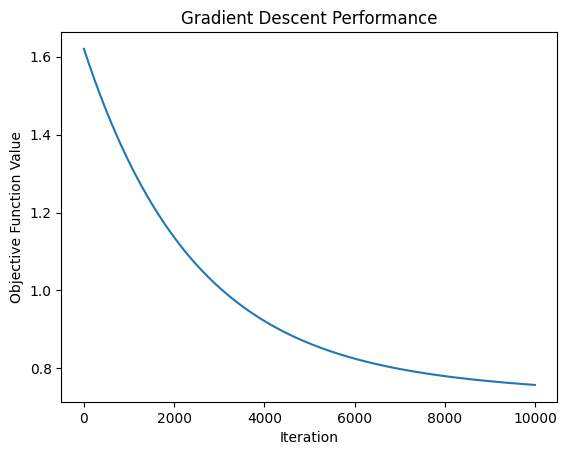

Final solution: [0.13419702 0.02705034]


In [20]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Apr  8 00:46:26 2024

@author: nikola
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import minimize
import time
import math
import datetime
import scipy as sc
import scipy.stats as ss
import random

# Define the Rosenbrock function
def rosenbrock(x):
    a = 1
    b = 100
    return (a - x[0])**2 + b * (x[1] - x[0]**2)**2

def drosebrock(X):
    a = 1
    b = 100
    dLambda = np.zeros(len(X))
    h = 1e-3  # Step size for finite difference
    for i in range(len(X)):
        dX = np.zeros(len(X))
        dX[i] = h
        dLambda[i] = (rosenbrock(X + dX) - rosenbrock(X - dX)) / (2 * h)
    return dLambda

def gradient_descent(objective, step_size, n_iterations, initial_solution):
    solutions = []  # Store solutions for visualization
    scores = []     # Store scores for visualization

    solution = initial_solution
    solution_eval = objective(initial_solution)
    
    # Iterative optimization loop
    for i in range(n_iterations):
        gradient = drosebrock(solution)  # Compute gradient
        new_solution = solution - step_size * gradient  # Update solution
        new_solution_eval = objective(new_solution)    # Evaluate new solution
        
        # Update solution if improvement is found
        if new_solution_eval < solution_eval:
            solution = new_solution
            solution_eval = new_solution_eval
            solutions.append(solution)
            scores.append(solution_eval)
            print('>%d f(%s) = %.5f' % (i, solution, solution_eval))
            
    return solutions, scores

# Set seed for reproducibility
#seed(1)

# Parameters
n_iterations = 10000
step_size = 0.000001
initial_solution = [0.1, 0.1]

# Perform gradient descent
solutions, scores = gradient_descent(rosenbrock, step_size, n_iterations, initial_solution)

# Visualize the optimization process
plt.plot(scores)
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.title('Gradient Descent Performance')
plt.show()

# Print the final solution
final_solution = solutions[-1]
print("Final solution:", final_solution)
